In [28]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [29]:
import FinanceDataReader as fdr

# 삼성전자

In [30]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005930', '2020-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-01-16,54200,55000,54100,54300,18627298,0.011173
2025-01-17,53800,54100,53200,53700,18805344,-0.011050
2025-01-20,53600,53900,53300,53400,11822531,-0.005587
2025-01-21,53700,54300,53300,53500,13535702,0.001873
2025-01-22,53400,54400,53100,54300,18175738,0.014953


# 분석 코드

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

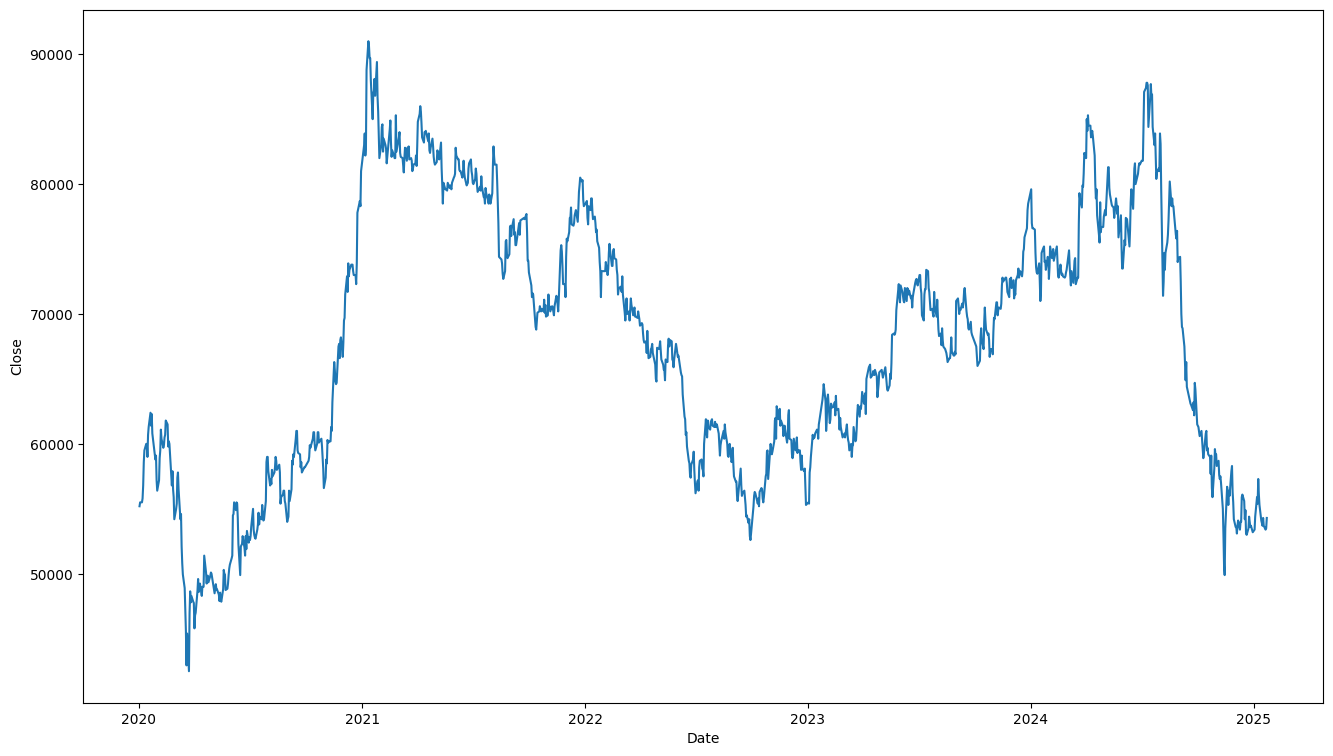

In [33]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [34]:
# 종가 제외 스케일링 (예측변수 = 종가)
# 데이터프레임의 'Open', 'High', 'Low', 'Close', 'Volume' 열을 MinMaxScaler로 0과 1 사이로 정규화
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [35]:
# 예측에 사용할 입력 데이터(x)와 타겟 데이터(y)를 각각 넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

# 주어진 입력 데이터와 타겟 데이터를 시퀀스 형태로 변환
def seq_data(x, y, sequence_length):
  x_seq = [] # 시퀀스 입력 데이터를 저장할 리스트
  y_seq = [] # 시퀀스 타겟 데이터를 저장할 리스트
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # 입력 데이터는 sequence_length 길이만큼 묶어서 저장
    y_seq.append(y[i + sequence_length]) # 타겟 데이터는 현재 시점 + sequence_length의 값을 저장

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [36]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([1041, 5, 4]) torch.Size([1041, 1])


In [37]:
# 학습 데이터와 테스트 데이터 확인
x_train_seq

tensor([[[0.2704, 0.2338, 0.2691, 0.0855],
         [0.2809, 0.2451, 0.2669, 0.1142],
         [0.2579, 0.2263, 0.2606, 0.0534],
         [0.2746, 0.2413, 0.2818, 0.0502],
         [0.2851, 0.2601, 0.2881, 0.2098]],

        [[0.2809, 0.2451, 0.2669, 0.1142],
         [0.2579, 0.2263, 0.2606, 0.0534],
         [0.2746, 0.2413, 0.2818, 0.0502],
         [0.2851, 0.2601, 0.2881, 0.2098],
         [0.3312, 0.2826, 0.3199, 0.2169]],

        [[0.2579, 0.2263, 0.2606, 0.0534],
         [0.2746, 0.2413, 0.2818, 0.0502],
         [0.2851, 0.2601, 0.2881, 0.2098],
         [0.3312, 0.2826, 0.3199, 0.2169],
         [0.3396, 0.3033, 0.3390, 0.1210]],

        ...,

        [[0.3711, 0.3258, 0.3771, 0.1604],
         [0.3899, 0.3371, 0.3877, 0.1175],
         [0.3711, 0.3183, 0.3708, 0.1009],
         [0.3732, 0.3164, 0.3708, 0.0420],
         [0.3732, 0.3296, 0.3771, 0.0887]],

        [[0.3899, 0.3371, 0.3877, 0.1175],
         [0.3711, 0.3183, 0.3708, 0.1009],
         [0.3732, 0.3164, 0.3708

In [38]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

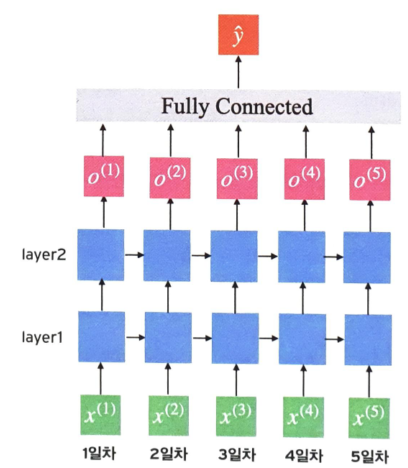

In [39]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [40]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [41]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [42]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [43]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0273
[epoch : 10] loss: 0.0051
[epoch : 20] loss: 0.0015
[epoch : 30] loss: 0.0011
[epoch : 40] loss: 0.0010


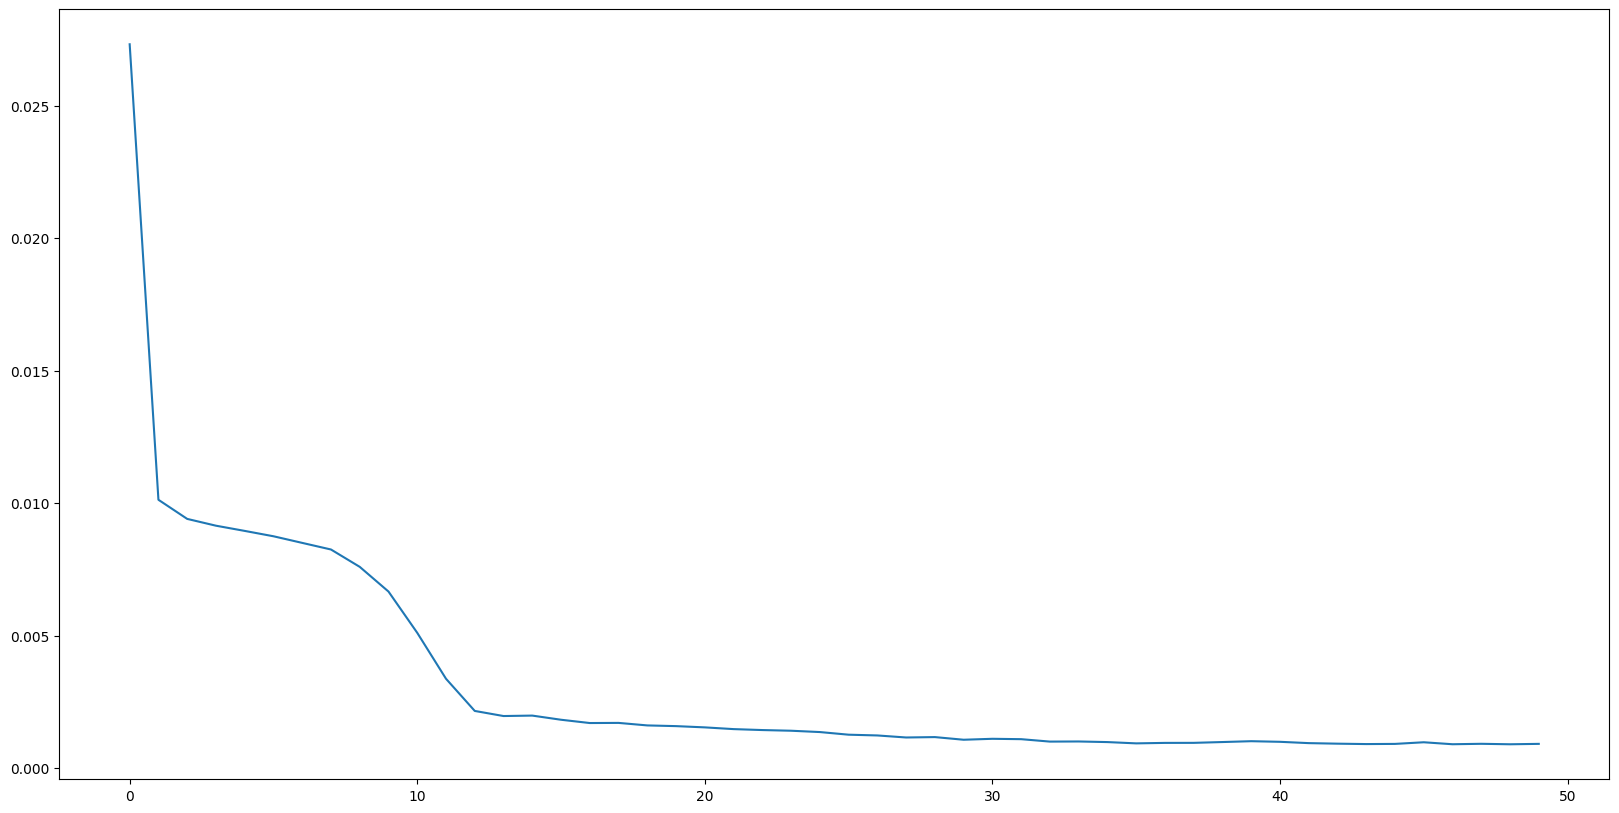

In [44]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [45]:
# 학습 데이터셋과 테스트 데이터셋을 하나의 데이터셋으로 합침
concatdata = torch.utils.data.ConcatDataset([train, test])

# 합쳐진 데이터셋을 DataLoader에 로드
# batch_size를 100으로 설정하여 한 번에 100개의 데이터를 처리
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

# 평가 모드에서 예측값 생성
with torch.no_grad():
  pred = [] # 모델의 예측값을 저장할 리스트
  model.eval() # 평가 모드
  for data in data_loader:
    seq, target = data # DataLoader에서 배치 단위로 시퀀스(seq)와 타겟(target)을 가져옴
    out = model(seq) # 모델을 통해 예측값(out)을 생성
    pred += out.cpu().tolist()

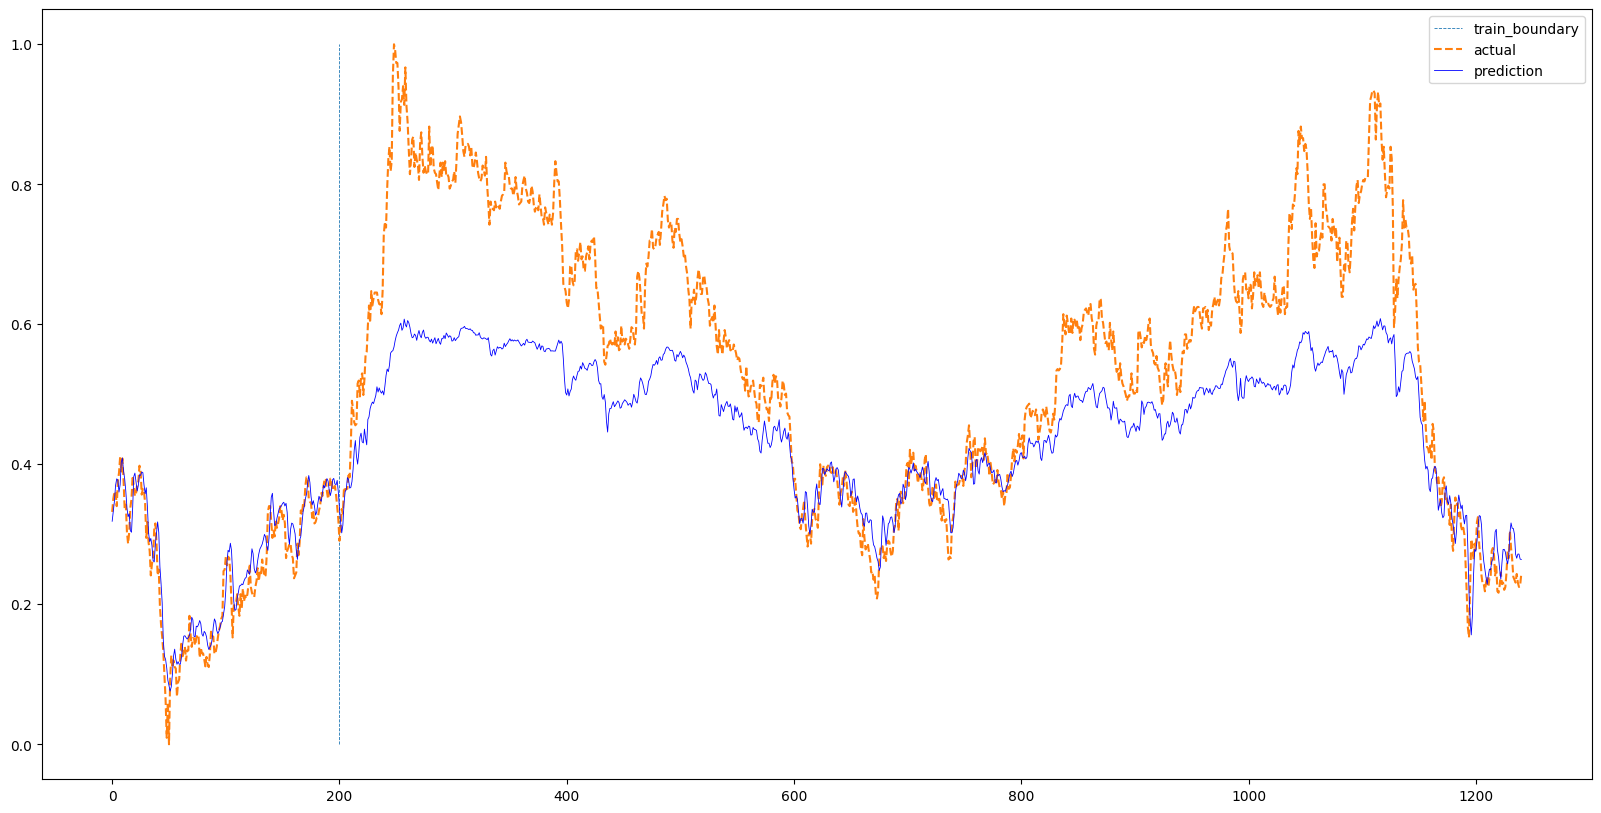

In [46]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [47]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [48]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [49]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [50]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [51]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0102
[epoch: 10] loss: 0.0016
[epoch: 20] loss: 0.0014
[epoch: 30] loss: 0.0012
[epoch: 40] loss: 0.0010


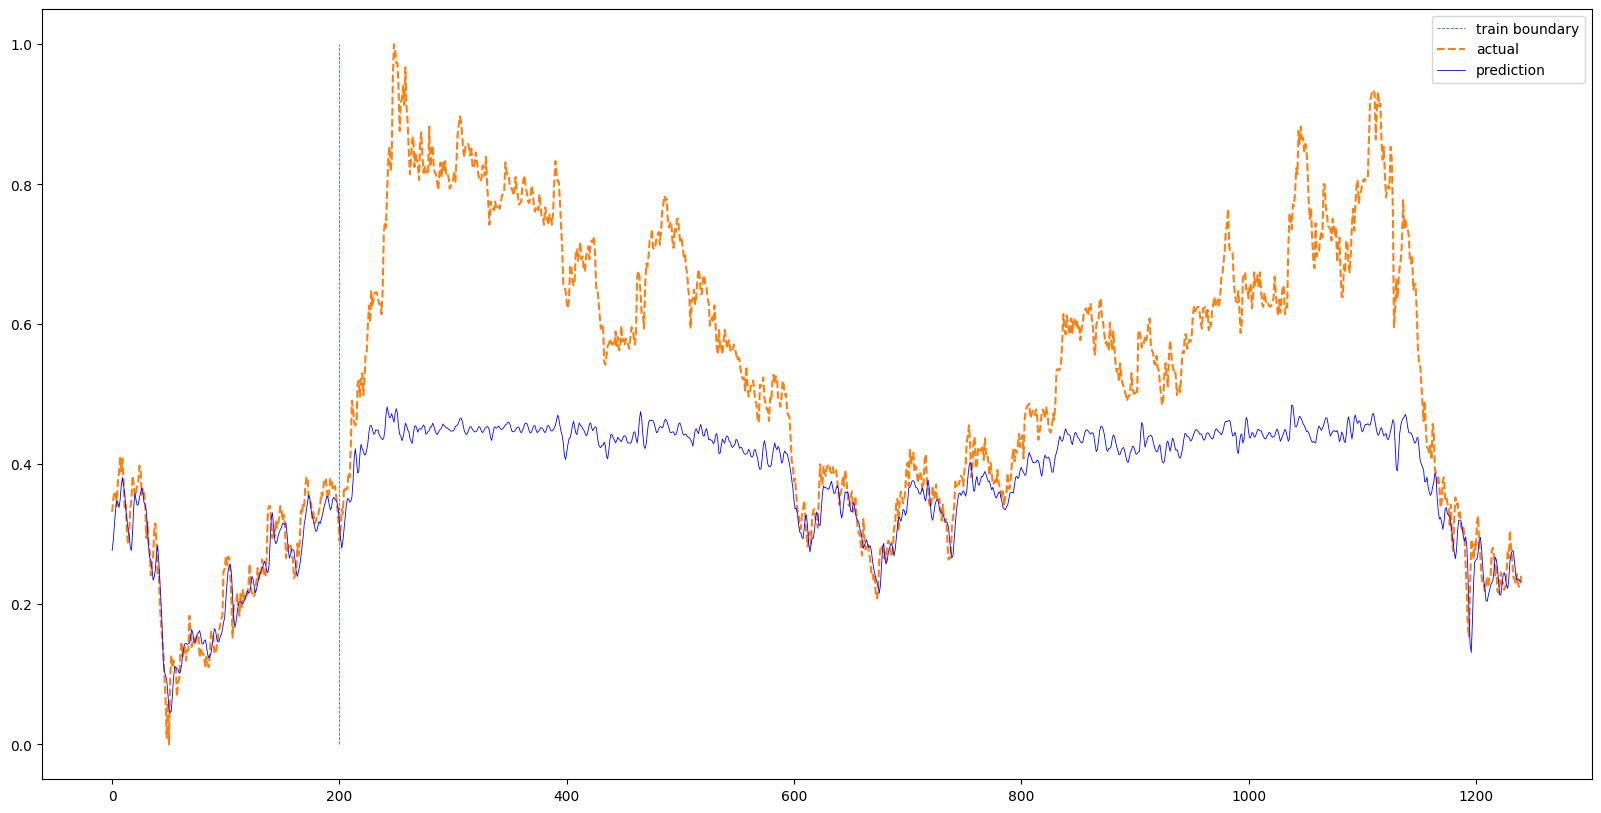

In [52]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [59]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail

<bound method NDFrame.tail of               Open    High     Low   Close  Volume    Change
Date                                                        
2024-01-02  202000  202500  199800  200500  373050 -0.014742
2024-01-03  199100  199500  193800  193800  548675 -0.033416
2024-01-04  192000  192800  189100  190000  505979 -0.019608
2024-01-05  190100  190500  187200  187300  440219 -0.014211
2024-01-08  187600  188900  185500  185700  323498 -0.008542
...            ...     ...     ...     ...     ...       ...
2025-01-16  223000  224000  218000  219000  435312 -0.006803
2025-01-17  217500  218000  211000  211500  813817 -0.034247
2025-01-20  211000  212000  207500  208500  571176 -0.014184
2025-01-21  210500  213000  206500  206500  833996 -0.009592
2025-01-22  207500  210000  206500  208500  829006  0.009685

[259 rows x 6 columns]>

## 전처리

In [60]:
# 종가 제외 스케일링 (예측변수 = 종가)
# 데이터프레임의 'Open', 'High', 'Low', 'Close', 'Volume' 열을 MinMaxScaler로 0과 1 사이로 정규화
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [61]:
# 예측에 사용할 입력 데이터(x)와 타겟 데이터(y)를 각각 넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

# 주어진 입력 데이터와 타겟 데이터를 시퀀스 형태로 변환
def seq_data(x, y, sequence_length):
  x_seq = [] # 시퀀스 입력 데이터를 저장할 리스트
  y_seq = [] # 시퀀스 타겟 데이터를 저장할 리스트
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length]) # 입력 데이터는 sequence_length 길이만큼 묶어서 저장
    y_seq.append(y[i + sequence_length]) # 타겟 데이터는 현재 시점 + sequence_length의 값을 저장

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [62]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length)

#순서대로 70개는 학습, 나머지는 평가
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([54, 5, 4]) torch.Size([54, 1])


In [63]:
# 학습 데이터와 테스트 데이터 확인
x_train_seq

tensor([[[0.1841, 0.1716, 0.1767, 0.0262],
         [0.1598, 0.1460, 0.1237, 0.0575],
         [0.1004, 0.0888, 0.0822, 0.0499],
         [0.0845, 0.0692, 0.0654, 0.0382],
         [0.0636, 0.0555, 0.0504, 0.0174]],

        [[0.1598, 0.1460, 0.1237, 0.0575],
         [0.1004, 0.0888, 0.0822, 0.0499],
         [0.0845, 0.0692, 0.0654, 0.0382],
         [0.0636, 0.0555, 0.0504, 0.0174],
         [0.0653, 0.0461, 0.0504, 0.0219]],

        [[0.1004, 0.0888, 0.0822, 0.0499],
         [0.0845, 0.0692, 0.0654, 0.0382],
         [0.0636, 0.0555, 0.0504, 0.0174],
         [0.0653, 0.0461, 0.0504, 0.0219],
         [0.0469, 0.0418, 0.0477, 0.0187]],

        ...,

        [[0.5105, 0.5004, 0.4258, 0.1751],
         [0.3891, 0.4150, 0.3595, 0.1586],
         [0.3849, 0.3980, 0.3905, 0.0736],
         [0.3849, 0.3766, 0.3640, 0.0926],
         [0.3598, 0.3638, 0.3595, 0.0585]],

        [[0.3891, 0.4150, 0.3595, 0.1586],
         [0.3849, 0.3980, 0.3905, 0.0736],
         [0.3849, 0.3766, 0.3640

In [64]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

## BiLSTM

일반 LSTM은 데이터를 **한 방향(순방향)**으로만 처리합니다. 즉, 시간 순서대로 입력을 처리하며 과거 정보만을 이용하여 현재 상태를 예측하는 반면, BiLSTM은 순방향뿐만 아니라 **역방향(시간 역순)**으로도 데이터를 처리하여 과거와 미래의 정보를 모두 활용한다.

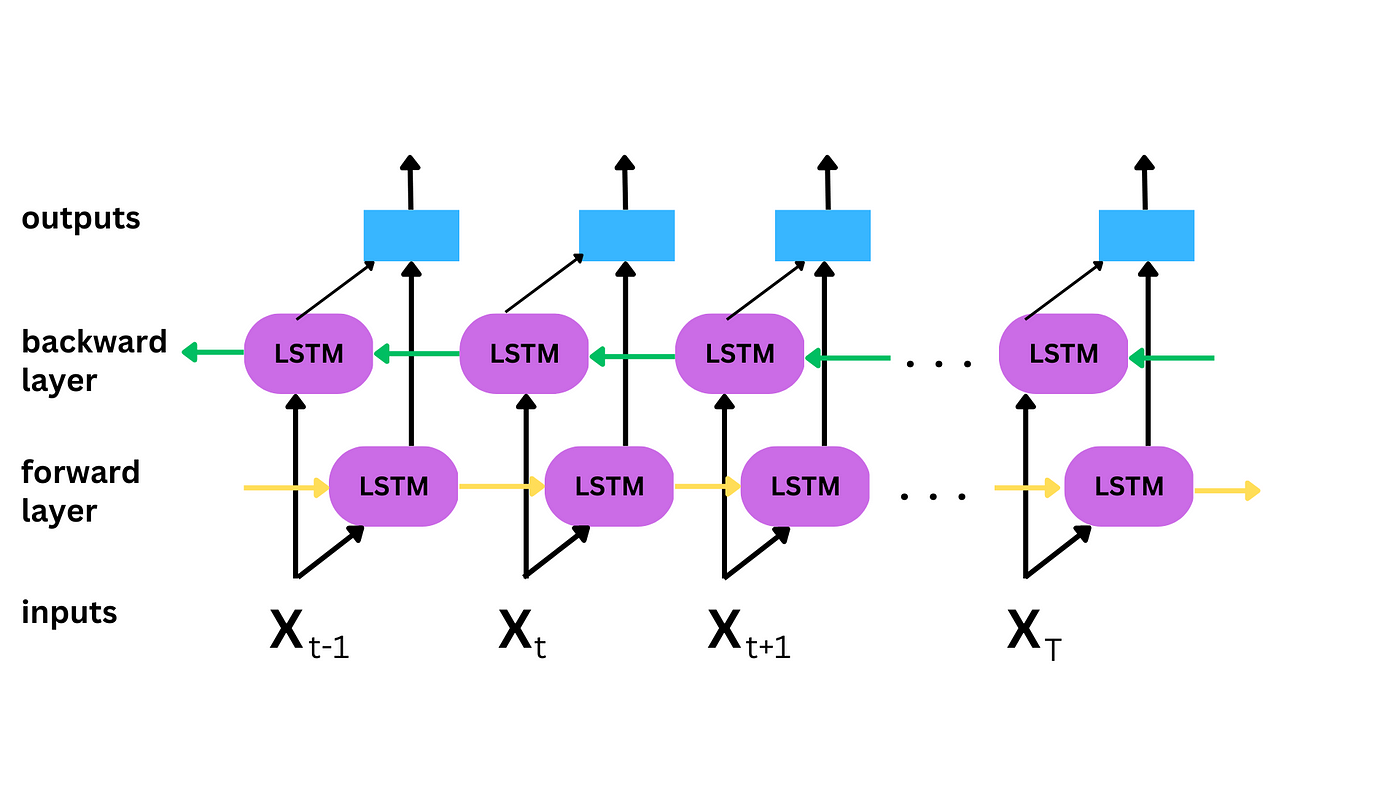

BiLSTM은 내부적으로 두 개의 LSTM 계층을 사용하는데, 순방향 LSTM은 데이터를 왼쪽에서 오른쪽(과거 → 현재)으로 처리하며, 역방향 LSTM: 데이터를 오른쪽에서 왼쪽(미래 → 현재)으로 처리한다.

최종 출력은 순방향과 역방향의 결과를 합치거나 연결한 벡터로 표현된다.

In [69]:
# 하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 4
hidden_size = 16

# BiLSTM 모델 클래스 정의
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True  # BiLSTM 사용
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=self.bidirectional)
        # 양방향이므로 hidden_size * 2
        self.fc = nn.Linear(hidden_size * 2 * sequence_length, 1)

    def forward(self, x):
        # 초기 hidden state와 cell state 생성
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)  # 2: 양방향
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))
        # Flatten (reshape) the output
        out = out.reshape(out.shape[0], -1)  # (batch_size, sequence_length * hidden_size * 2)
        # Fully connected layer
        out = self.fc(out)
        return out

# 모델 생성
model = BiLSTM(input_size=input_size,
               hidden_size=hidden_size,
               sequence_length=sequence_length,
               num_layers=num_layers,
               device=device).to(device)

In [66]:
criterion = nn.MSELoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [67]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.0822
[epoch: 10] loss: 0.0058
[epoch: 20] loss: 0.0055
[epoch: 30] loss: 0.0047
[epoch: 40] loss: 0.0049
[epoch: 50] loss: 0.0040
[epoch: 60] loss: 0.0039
[epoch: 70] loss: 0.0039
[epoch: 80] loss: 0.0037
[epoch: 90] loss: 0.0033


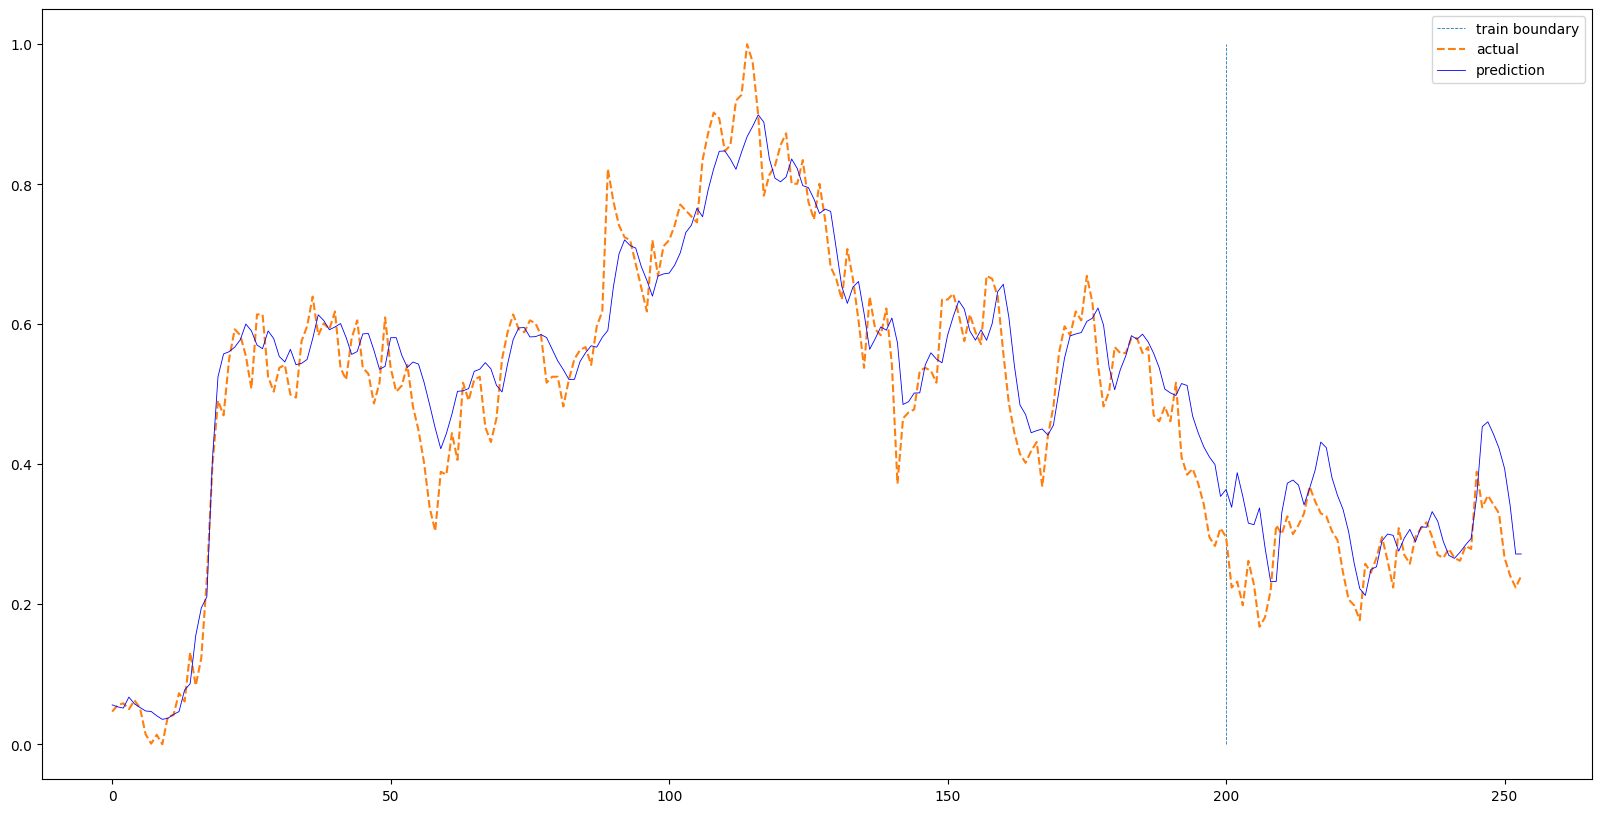

In [68]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()